# Project 05 - Ensemble Machine Learning - Wine Dataset
Author:  Beth Spornitz  
Date:  November 20, 2025

## Introduction
In this project, we learn how to implement and evaluate more complex models when simpler techniques aren't enough. We'll explore ensemble models, a powerful approach in machine learning that combines multiple models to improve performance. Ensemble methods often outperform individual models by reducing overfitting and improving generalization.




## Imports



In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
)

## Section 1.  Load and Inspect the Data

In [40]:
# Load the dataset (download from UCI and save in the same folder)
df = pd.read_csv(r"C:\Repos\ml-bethspornitz\notebooks\project05\data\winequality-red.csv", sep=";")

# Display structure and first few rows
df.info()
df.head()

# The dataset includes 11 physicochemical input variables (features):
# ---------------------------------------------------------------
# - fixed acidity          mostly tartaric acid
# - volatile acidity       mostly acetic acid (vinegar)
# - citric acid            can add freshness and flavor
# - residual sugar         remaining sugar after fermentation
# - chlorides              salt content
# - free sulfur dioxide    protects wine from microbes
# - total sulfur dioxide   sum of free and bound forms
# - density                related to sugar content
# - pH                     acidity level (lower = more acidic)
# - sulphates              antioxidant and microbial stabilizer
# - alcohol                % alcohol by volume

# The target variable is:
# - quality (integer score from 0 to 10, rated by wine tasters)

# We will simplify this target into three categories:
#   - low (3–4), medium (5–6), high (7–8) to make classification feasible.
#   - we will also make this numeric (we want both for clarity)
# The dataset contains 1599 samples and 12 columns (11 features + target).


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Section 2.  Prepare the Data

We are looking at integers from 3 to 8, when we are working with wine quality ratings. To make the data more understandable for classification models, we can use the `quality_to_label()` function to convert those ratings into categorical labels: 
- **Low** for ratings 3-4
- **Medium** for ratings 5-6
- **High** for ratings 7-8

We can use the `quality_to_number()` function to map those categories to the numeric values which machine learning algorithms can work with. 
- 0 - Low 
- 1 - Medium 
- 2 - High 
  
Having both a readable label column and a numeric column will allow us to easily interpret the results of our models in a table or plot and also enables efficient model training.

In [41]:
# Define helper function that:

# Takes one input, the quality (which we will temporarily name q while in the function)
# And returns a string of the quality label (low, medium, high)
# This function will be used to create the quality_label column
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"


# Call the apply() method on the quality column to create the new quality_label column
df["quality_label"] = df["quality"].apply(quality_to_label)


# Then, create a numeric column for modeling: 0 = low, 1 = medium, 2 = high
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2


df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Verify that the new columns were added correctly
print("\nUnique quality labels:", df["quality_label"].unique())
print("Unique quality numbers:", df["quality_numeric"].unique())
print("\nCounts per label:")
print(df["quality_label"].value_counts())

#  first few rows
df[["quality", "quality_label", "quality_numeric"]].head(10)



Unique quality labels: ['medium' 'high' 'low']
Unique quality numbers: [1 2 0]

Counts per label:
quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64


,quality,quality_label,quality_numeric
0,5,medium,1
1,5,medium,1
2,5,medium,1
3,6,medium,1
4,5,medium,1
5,5,medium,1
6,5,medium,1
7,7,high,2
8,7,high,2
9,5,medium,1


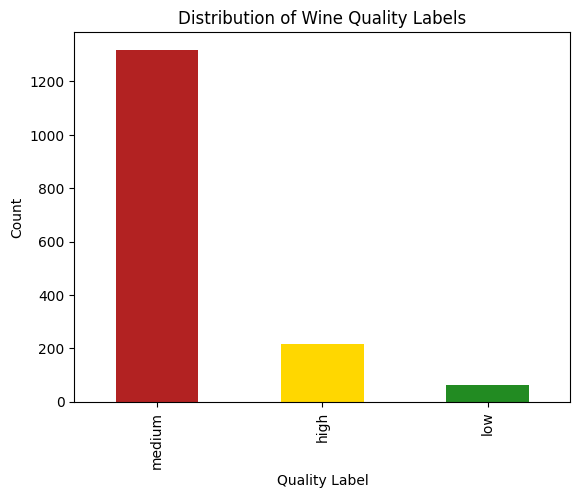

In [42]:
# Visualize class counts
df["quality_label"].value_counts().plot(kind="bar", color=["#B22222","#FFD700","#228B22"])
plt.title("Distribution of Wine Quality Labels")
plt.xlabel("Quality Label")
plt.ylabel("Count")
plt.show()



The bar chart shows that most samples are "medium quality".

## Section 3.  Feature Selection and Justification

When training a model, we need to determine the variables that will be input and output, also known as features and target. In the case of this wine dataset, we're looking at properties such as acidity, sugar, chlorides, sulphates and alcohol content, as our input features X. 

Since we’re not actually predicting the physical properties themselves, we drop columns quality, quality_label, and quality_numeric out of the features. As these basically tell us the outcome we’re trying to achieve. 

Our target variable, or y, is going to be the numeric version of wine quality, coded as 0 for low, 1 for medium and 2 for high.

In [43]:
# Define input features (X) and target (y)
# Features: all columns except 'quality' and 'quality_label' and 'quality_numberic' - drop these from the input array
# Target: quality_label (the new column we just created)
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])  # Features
y = df["quality_numeric"]  # Target

Counting the number of values in each category is a good way to confirm that our classes are balanced, and that no category is missing.

Checking the value counts shows that most wines fall in the medium-quality category. This tells us that the dataset is slightly imbalanced, and accuracy alone may not be enough so we will need to use metrics like F1 Score to help evaluate performance more fairly.

In [44]:
# Quick check to confirm features and target look correct
print("Feature columns (X):")
print(X.columns.tolist())
print("\nNumber of features:", X.shape[1])
print("Number of rows:", X.shape[0])

print("\nTarget variable (y) distribution:")
print(y.value_counts().sort_index())

# Display first few rows to visually confirm structure
X.head()


Feature columns (X):
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Number of features: 11
Number of rows: 1599

Target variable (y) distribution:
quality_numeric
0      63
1    1319
2     217
Name: count, dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


## Section 4. Split the Data into Train and Test

We divide the dataset into training and testing sets. Eighty percent of the data is used to train our models and the remaining 20% is kept aside to see how they perform on unrecognized wine types. 

We use the stratify=y parameter to prevent the test set from being imbalanced. This is because it’s not fair to give the model a skewed test set, for example, with lots of medium-quality wines, because it would artificially inflate the accuracy. 

We have also set random_state = 42 so that anyone who runs the same script will get exactly the same split. 

When we look at the distribution of our classes, it’s good to see that the split was successful and gave us a balanced set.


In [45]:
# Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [46]:
# Quick confirmation of sizes and class balance
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).sort_index())

Training set size: 1279
Test set size: 320

Class distribution in training set:
quality_numeric
0    0.039093
1    0.824863
2    0.136044
Name: proportion, dtype: float64

Class distribution in test set:
quality_numeric
0    0.040625
1    0.825000
2    0.134375
Name: proportion, dtype: float64


## Section 5.  Evaluate Model Performance

We are trying to determine which of two ensemble methods, Gradient Boosting (100) or Voting Classifier (DT + SVM + NN), will be the best at predicting wine quality we need to evaluate their performance. 

Well-known ensemble methods combine the strengths to outperform individual models, and I've chosen these two to give us a good understanding of what works best. 

Gradient Boosting, using its sequential method to build each new decision tree, taking into account the errors of the previous ones.  This is a very effective system, especially when dealing with structured tabular data and it often yields high accuracy with only moderate fine-tuning. 

On the other hand, the Voting Classifier is a melting pot of three completely different kinds of algorithms: a Decision Tree, a Support Vector Machine, and a Neural Network that get together and pool their ideas, by soft-voting. Basically, this is averaging out the predictions of each one, so that the stronger ideas get heard more often. 

We will train, evaluate, and compare both using accuracy and F1 score on the training and testing sets.  
Smaller gaps between training and testing results indicate better generalization. Larger gaps suggest overfitting.



In [47]:

# Helper function
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )


### Section 5.1 Gradient Boosting

In [48]:
results = []
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    X_train, y_train, X_test, y_test, results,
)



Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  3 247  14]
 [  0  16  27]]
Train Accuracy: 0.9601, Test Accuracy: 0.8562
Train F1 Score: 0.9584, Test F1 Score: 0.8411


### Gradient Boosting Confusion Matrix

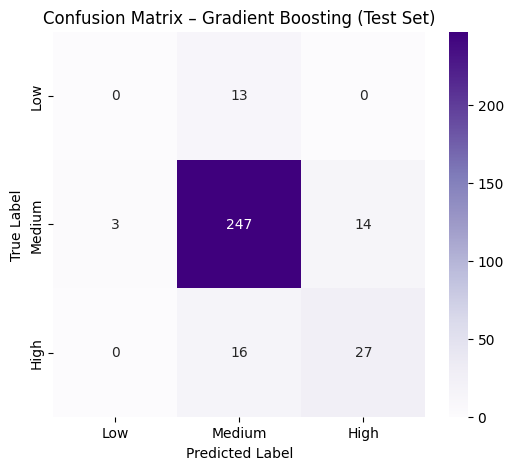

In [49]:
# Get predictions again for visualization
y_test_pred = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
).fit(X_train, y_train).predict(X_test)

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
labels = ["Low", "Medium", "High"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", 
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Gradient Boosting (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Gradient Boosting Model - Confusion Matrix Interpretation

The confusion matrix shows that the Gradient Boosting model performs very well on the medium quality wines and moderately well on high quality wines.  

- The model correctly classified most of the medium wines.  (247 correct).  
- The model  predicted high quality wines correctly (27 correct) but sometimes confused with medium wines.  
- Low quality wines were all predicted as medium probably because there are so few examples for the model to learn from.

This model has an 85% test accuracy and a good F1 score (.84).  This means the model has very reliable performance.


### Gradient Boosting Bar Chart (Actual vs Predicted)

Total actual samples: 320
Total predicted samples: 320


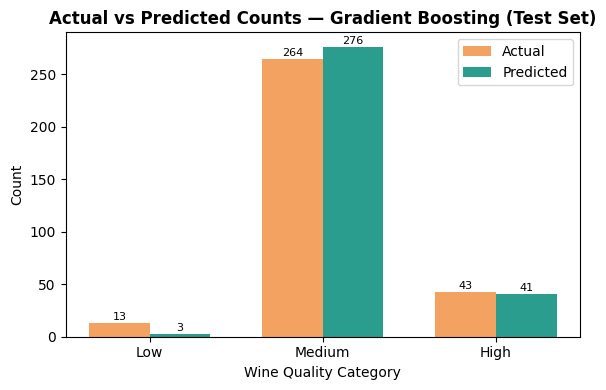

In [50]:


# Confirm predicted values (in case not stored yet)
y_test_pred = gb_model.predict(X_test)

# Define label names and numeric order
labels = ["Low", "Medium", "High"]

# Manually count actual vs predicted
actual_counts = [sum(y_test == 0), sum(y_test == 1), sum(y_test == 2)]
pred_counts = [sum(y_test_pred == 0), sum(y_test_pred == 1), sum(y_test_pred == 2)]

# Verify totals
print(f"Total actual samples: {sum(actual_counts)}")
print(f"Total predicted samples: {sum(pred_counts)}")

# Set up bar chart
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
bars1 = ax.bar(x - width/2, actual_counts, width, label="Actual", color="#f4a261")
bars2 = ax.bar(x + width/2, pred_counts, width, label="Predicted", color="#2a9d8f")

# Labels and title
ax.set_xlabel("Wine Quality Category", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Actual vs Predicted Counts — Gradient Boosting (Test Set)", fontsize=12, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add data labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.tight_layout()
plt.show()


### Gradient Boosting Bar Chart Interpretation

The bar chart above compares the number of wines in each true (actual) quality category (orange) 
to how many the model predicted (green).

We can see that:
- The Medium category dominates both the actual and predicted counts, so this may explains the strong overall accuracy.
- The High category wines are slightly under predicted, and they are often being confused as Medium.
- The Low category wines were misclassified as Medium category.  This shows the model needs more examples of the low category to learn from.

This visual helps confirm the Gradient Boosting model performs best on the medium category wines.


## Section 5.2 - Voting Classifier (DT + SVM + NN)

The Voting Classifier is a model that combines multiple approaches to improve accuracy.  It combines the predictions from several different models and then makes a final decision.   We are combining: 
- Decision Tree (DT)
- Support Vector Machine (SVM)  
- Neural Network (NN) 
  
Each of these models have strengths and weaknesses. Our model combines the strengths of each three components. To do so, it uses a soft voting method, which takes the average of the probabilities given by each individual model to come to a conclusion about the final classification.

In [51]:
# Define the Voting Classifier first
voting1 = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier()),
        ("SVM", SVC(probability=True)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ],
    voting="soft",
)


evaluate_model(
    "Voting (DT + SVM + NN)", voting1, X_train, y_train, X_test, y_test, results
)



Voting (DT + SVM + NN) Results
Confusion Matrix (Test):
[[  0  12   1]
 [  0 250  14]
 [  0  17  26]]
Train Accuracy: 0.9195, Test Accuracy: 0.8625
Train F1 Score: 0.9000, Test F1 Score: 0.8429


### Voting Classifier Confusion Matrix Heatmap

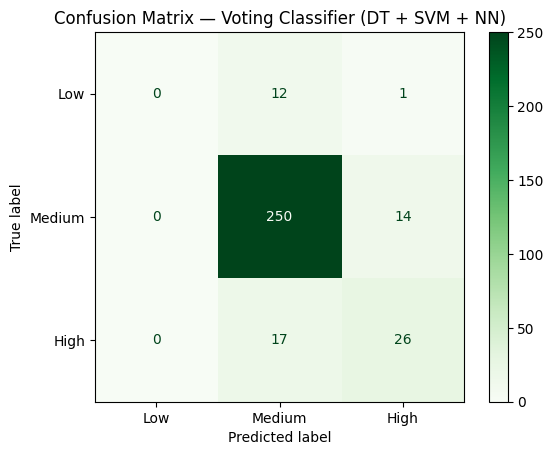

In [54]:

# Predict with the voting model
y_test_pred_voting = voting1.predict(X_test)

# Confusion Matrix Heatmap
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_test_pred_voting, 
    cmap="Greens", 
    display_labels=["Low", "Medium", "High"]
)
plt.title("Confusion Matrix — Voting Classifier (DT + SVM + NN)")
plt.show()


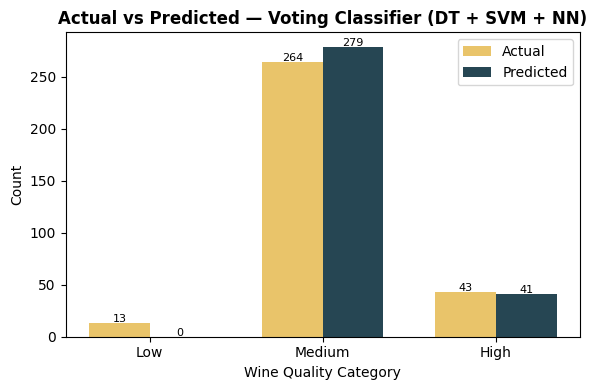

In [55]:
labels = ["Low", "Medium", "High"]

actual_counts = [sum(y_test == 0), sum(y_test == 1), sum(y_test == 2)]
pred_counts_voting = [sum(y_test_pred_voting == 0), sum(y_test_pred_voting == 1), sum(y_test_pred_voting == 2)]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
bars1 = ax.bar(x - width/2, actual_counts, width, label="Actual", color="#e9c46a")
bars2 = ax.bar(x + width/2, pred_counts_voting, width, label="Predicted", color="#264653")

ax.set_xlabel("Wine Quality Category", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Actual vs Predicted — Voting Classifier (DT + SVM + NN)", fontsize=12, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f"{int(height)}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


In [57]:


results_df = pd.DataFrame(results).assign(
    Acc_Gap=lambda d: d["Train Accuracy"] - d["Test Accuracy"],
    F1_Gap=lambda d: d["Train F1"] - d["Test F1"]
).sort_values(by="Test Accuracy", ascending=False)

print("\nSummary of Selected Models (sorted by Test Accuracy):")
display(results_df)



Summary of Selected Models (sorted by Test Accuracy):


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Acc_Gap,F1_Gap
1,Voting (DT + SVM + NN),0.919468,0.86250,0.899985,0.842853,0.056968,0.057132
0,Gradient Boosting (100),0.960125,0.85625,0.958410,0.841106,0.103875,0.117304


C:\Users\beths\AppData\Local\Temp\ipykernel_9904\3464818616.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Test Accuracy", palette="viridis")


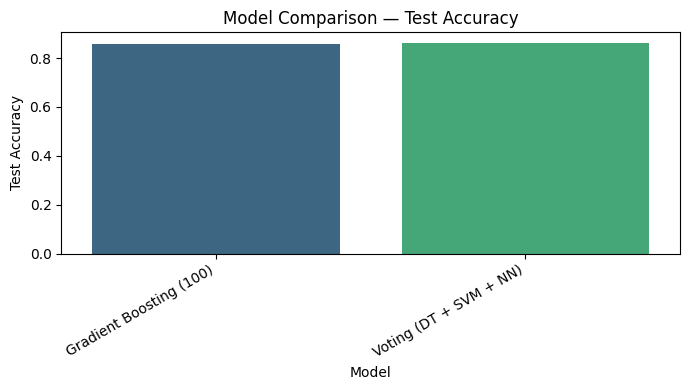

In [58]:


results_df = pd.DataFrame(results)

plt.figure(figsize=(7, 4))
sns.barplot(data=results_df, x="Model", y="Test Accuracy", palette="viridis")
plt.title("Model Comparison — Test Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()